# Command line for ML.net

[ML.net](https://github.com/dotnet/machinelearning) hides a command line available through DLL Microsoft.ML.Tools.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

We add magic command ``%%maml``.

In [3]:
%load_ext csharpyml

## Maml help

An example on how to get help.

In [4]:
%%maml -q

?

In [5]:
%%maml

? traintest

Help for Command: 'TrainTest'
Summary:
   Trains a predictor using the train file and then scores and evaluates the predictor using the test file.
testFile=<string>                     The test data file (short form test)
trainer=<name>{<options>}             Trainer to use (short form tr)
scorer=<name>{<options>}              Scorer to use
evaluator=<name>{<options>}           Evaluator to use (short form eval)
summaryFilename=<string>              Results summary filename (short form sf)
featureColumn=<string>                Column to use for features Default value:'Features' (short form feat)
labelColumn=<string>                  Column to use for labels Default value:'Label' (short form lab)
weightColumn=<string>                 Column to use for example weight Default value:'Weight' (short form weight)
groupColumn=<string>                  Column to use for grouping Default value:'GroupId' (short form group)
nameColumn=<string>                   Name column name Default value:'Nam

In [6]:
%%maml

? kind=trainer

Available components for kind 'Trainer':
  AveragedPerceptron: Averaged Perceptron
    Aliases: avgper, ap
  BinaryClassificationGamTrainer: Generalized Additive Model for Binary Classification
    Aliases: gam
  BinarySGD: Hogwild SGD (binary)
    Aliases: sgd
  EnsembleRegression: Regression Ensemble (bagging, stacking, etc)
  FastForestClassification: Fast Forest Classification
    Aliases: FastForest, ff, ffc
  FastForestRegression: Fast Forest Regression
    Aliases: ffr
  FastTreeBinaryClassification: FastTree (Boosted Trees) Classification
    Aliases: FastTreeClassification, FastTree, ft, ftc, FastRankBinaryClassification, FastRankBinaryClassificationWrapper, FastRankClassification, fr, btc, frc, fastrank, fastrankwrapper
  FastTreeRanking: FastTree (Boosted Trees) Ranking
    Aliases: ftrank, FastRankRanking, FastRankRankingWrapper, rank, frrank, btrank
  FastTreeRegression: FastTree (Boosted Trees) Regression
    Aliases: ftr, FastRankRegression, FastRankRegressionWrapper, fr

## With Iris

We first split the database into train and test.

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from pandas import DataFrame

iris = load_iris()
X = iris.data
y = iris.target
df = DataFrame(X, columns=['Slength', 'Swidth', 'Plength', 'Pwidth'])
df["Label"] = y
df = df[["Label"] + ['Slength', 'Swidth', 'Plength', 'Pwidth']]
dftrain, dftest = train_test_split(df)
dftrain.to_csv("iris_data_id_train.txt", sep=',', index=False)
dftest.to_csv("iris_data_id_test.txt", sep=',', index=False)

And we run the [command line of maml](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/commandline.html) to train and test a multi-logistic regression.

In [8]:
%%maml

traintest
data=iris_data_id_train.txt
test=iris_data_id_test.txt
loader=text{col=Label:U4[0-2]:0 col=Slength:R4:1 col=Swidth:R4:2 col=Plength:R4:3 col=Pwidth:R4:4 sep=, header=+}
xf=Concat{col=Features:Slength,Swidth}
tr=mlr
out=model.zip
dout=prediction.txt

maml.exe TrainTest test=iris_data_id_test.txt tr=mlr dout=prediction.txt loader=text{col=Label:U4[0-2]:0 col=Slength:R4:1 col=Swidth:R4:2 col=Plength:R4:3 col=Pwidth:R4:4 sep=, header=+} data=iris_data_id_train.txt out=model.zip xf=Concat{col=Features:Slength,Swidth}
Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
[1] 'Normalize' started.
LBFGS multi-threading will attempt to load dataset into memory. In case of out-of-memory issues, add 'numThreads=1' to the trainer arguments and 'cache=-' to the command line arguments to turn off multi-threading.
Beginning optimization
num vars: 9
improvement criterion: Mean Improvement
L1 regularization selected 7 of 9 weights.
Not training a calibrator because it is not needed.
[1] (00:00.13)	112 examples
[1] 'Normalize' finished in 00:00:00.1384867.
[2] 'LBFGS data prep' started.
[2] 'LBFGS data prep' finished in 00:00:00.0139603.
[3] 'LBFGS Optimizer' started.
[3] (00:00.08)	0 iterati

Let's look at the prediction saved in ``predictions.txt``.

In [9]:
from pandas import read_csv
pred = read_csv("prediction.txt", sep="\t")
pred.head()

,Instance,Label,Assigned,Log-loss,#1 Score,#2 Score,#3 Score,#1 Class,#2 Class,#3 Class
0,0,2,1,1.087029,0.393746,0.337217,0.269037,1,2,0
1,1,0,0,0.803220,0.447885,0.329037,0.223078,0,1,2
2,2,1,1,0.885665,0.412440,0.298651,0.288909,1,2,0
3,3,2,1,1.407576,0.413521,0.341743,0.244736,1,0,2
4,4,0,0,0.803220,0.447885,0.329037,0.223078,0,1,2


## With a C# pipeline

The class *CSPipeline* wraps class [DataFrame](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/dataframe.html#dataframe) (C#). Let's rewrite the previous script.

In [10]:
iris = load_iris()
X = iris.data
y = iris.target
df = DataFrame(X, columns=['Slength', 'Swidth', 'Plength', 'Pwidth'])
df["Label"] = y
df = df[["Label"] + ['Slength', 'Swidth', 'Plength', 'Pwidth']]
dftrain, dftest = train_test_split(df)

In [11]:
from csharpyml.binaries import CSPipeline
pipe = CSPipeline(["Concat{col=Features:Slength,Swidth}"], "mlr")
pipe

In [12]:
try:
    pipe.fit(dftrain, "Features", "Label")
except Exception as e:
    print(e)

The pipeline only allows single float. Columns needs to be converted.

In [13]:
import numpy
df = df.astype(numpy.float32)
dftrain, dftest = train_test_split(df)

In [14]:
pipe.fit(dftrain, "Features", "Label")

Standard output does not seem to work yet from a notebook.

In [15]:
pipe.StdOut, pipe.StdErr

('', '')

In [16]:
pred = pipe.predict(dftest)
pred.head()

,Label,Slength,Swidth,Plength,Pwidth,Features.0,Features.1,PredictedLabel,Score.0,Score.1,Score.2
0,0.0,5.0,3.4,1.5,0.2,5.0,3.4,1,0.876764,0.099520,0.023716
1,2.0,6.3,3.3,6.0,2.5,6.3,3.3,3,0.094455,0.371040,0.534506
2,2.0,7.4,2.8,6.1,1.9,7.4,2.8,3,0.000669,0.194964,0.804367
3,2.0,7.2,3.2,6.0,1.8,7.2,3.2,3,0.003394,0.170807,0.825799
4,0.0,4.6,3.6,1.0,0.2,4.6,3.6,1,0.974559,0.021820,0.003620


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dftest["Label"], pred["PredictedLabel"] - 1)

array([[12,  0,  0],
       [ 0,  7,  2],
       [ 0,  6, 11]], dtype=int64)

## LightGBM

[ML.net](https://github.com/dotnet/machinelearning) wraps [LightGBM](https://github.com/Microsoft/LightGBM). Let's use the following classifier [LightGBM Multi-class Classifier](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/components/LightGBM_Multi-class_Classifier.html).

In [18]:
from csharpyml.binaries import CSPipeline
pipe = CSPipeline(["Concat{col=Features:Slength,Swidth}"], "LightGBMMC{iter=10}")
pipe.fit(dftrain, "Features", "Label")

In [19]:
pred2 = pipe.predict(dftest)
pred2.head()

,Label,Slength,Swidth,Plength,Pwidth,Features.0,Features.1,PredictedLabel,Score.0,Score.1,Score.2
0,0.0,5.0,3.4,1.5,0.2,5.0,3.4,1,0.882854,0.057847,0.059300
1,2.0,6.3,3.3,6.0,2.5,6.3,3.3,3,0.046021,0.463054,0.490925
2,2.0,7.4,2.8,6.1,1.9,7.4,2.8,3,0.051758,0.178676,0.769565
3,2.0,7.2,3.2,6.0,1.8,7.2,3.2,3,0.057311,0.090564,0.852125
4,0.0,4.6,3.6,1.0,0.2,4.6,3.6,1,0.884034,0.056587,0.059379


In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dftest["Label"], pred2["PredictedLabel"] - 1)

array([[12,  0,  0],
       [ 0,  7,  2],
       [ 0,  7, 10]], dtype=int64)

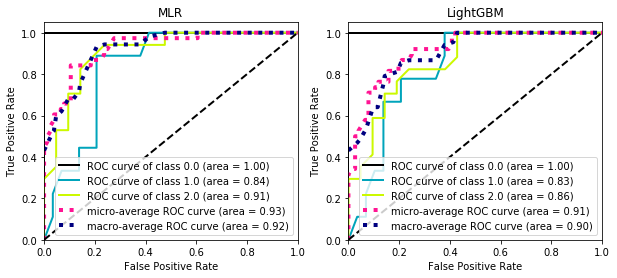

In [21]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_roc(dftest["Label"], pred[["Score.0", "Score.1", "Score.2"]], ax=ax[0])
plot_roc(dftest["Label"], pred2[["Score.0", "Score.1", "Score.2"]], ax=ax[1])
ax[0].set_title("MLR")
ax[1].set_title("LightGBM");